# Differential price response and Hi-Lo pricing

Once the demand model is developed, however, the optimization process for pricing decisions is relatively straightforward, and standard techniques such as linear or integer programming typically suffice. For instance, consider an apparel retailer that purchases a seasonal product at the beginning of the season and has to sell it out by the end of the period. Assuming that a retailer chooses pricing levels from a discrete set (e.g., $59.90, $69.90, etc.) and can make price changes frequently (e.g., weekly), we can pose the following optimization problem:

\begin{align}
\max{\sum_t\sum_j}p_j{d(t,j)}*x_{tj} \\
\text{subject to}
\sum_j{x_{tj}}=1, \text{for all t} \\
{\sum_t\sum_j}{d(t,j)}*x_{tj} = c \\
x_{tj}\in 0,1
\end{align}

where *t* iterates over time intervals, $j$ is an index that iterates over the valid price levels, $p_j$ is the price with index $j$, $d(t,j)$ is the demand at time $t$ given price level $j$, $c$ is the inventory level at the beginning of the season, and $x_{tj}$ is a binary dummy variable that is equal to one if price $j$ is assigned to time interval 
$t$, and zero otherwise. The first constraint ensures that each time interval has only one price, and the second constraint ensures that all demands sum up to the available stock level. This is an integer programming problem that can be solved using conventional optimization libraries.

# Demand model
Our model will take into account effect of positive and negative price change only.

\begin{align}
d(p_t, p_{t-1})=d_0-kp_t-as((p_t-p_{t-1})^+)+bs((p_t-p_{t-1})^-)\\
\text{where} \\
x^{+}=x \text{ if }x>0\text{, and } 0 \text { otherwise} \\
x^{-}=x \text{ if }x<0\text{, and } 0 \text { otherwise}
\end{align}

First two terms is linear dependency between price and demand. Third and fourth terms is elasticity to positive and negative price change. S function just to add non lineriality to our model and for our presentation we suppose $s=\sqrt{x}$

In [1]:
import math 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn-white')
import pandas as pd
from matplotlib import animation, rc
plt.rcParams.update({'pdf.fonttype': 'truetype'})

# from qbstyles import mpl_style
# mpl_style(dark=False)

def plus(x):
    return 0 if x < 0 else x

def minus(x):
    return 0 if x > 0 else -x

def shock(x):
    return np.sqrt(x)

# Demand at time step t for current price p_t and previous price p_t_1
def q_t(p_t, p_t_1, q_0, k, a, b):
    return plus(q_0 - k*p_t - a*shock(plus(p_t - p_t_1)) + b*shock(minus(p_t - p_t_1)))

# Profit at time step t
def profit_t(p_t, p_t_1, q_0, k, a, b, unit_cost):
    return q_t(p_t, p_t_1, q_0, k, a, b)*(p_t - unit_cost) 

# Total profit for price vector p over len(p) time steps
def profit_total(p, unit_cost, q_0, k, a, b):
    return profit_t(p[0], p[0], q_0, k, 0, 0, unit_cost) + sum(map(lambda t: profit_t(p[t], p[t-1], q_0, k, a, b, unit_cost), range(len(p))))

## Environment parameters
T = 50                # Time steps in the price schedule
price_max = 500       # Maximum valid price, dollars
price_step = 10       # Minimum valid price change, dollars
q_0 = 5000            # Intercept in the demand function q_t
k = 20                # Slope in the demand function, q_t
unit_cost = 100       # Product production cost, dollars
a_q = 300             # Response coefficient for price increase 
b_q = 100             # Response coefficient for price decrease

## Partial bindings for readability
def profit_t_response(p_t, p_t_1):
    return profit_t(p_t, p_t_1, q_0, k, a_q, b_q, unit_cost)

def profit_response(p):
    return profit_total(p, unit_cost, q_0, k, a_q, b_q)

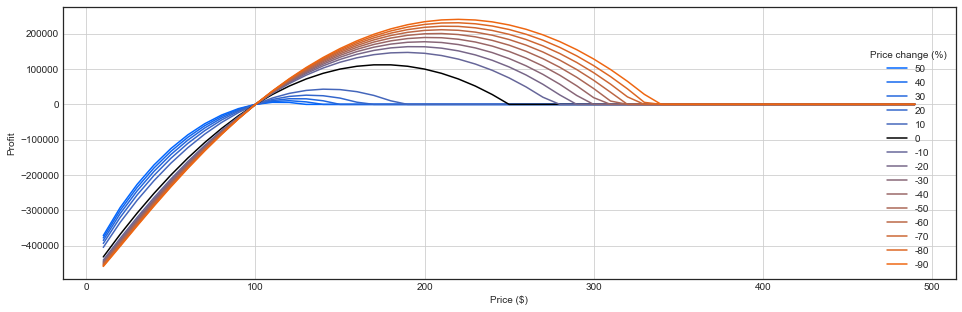

In [2]:
## Visualize price-demand functions
price_grid = np.arange(price_step, price_max, price_step)
price_change_grid = np.arange(0.5, 2.0, 0.1)
profit_map = np.zeros( (len(price_grid), len(price_change_grid)) )
for i in range(len(price_grid)):
    for j in range(len(price_change_grid)):
        profit_map[i,j] = profit_t_response(price_grid[i], price_grid[i]*price_change_grid[j])
plt.figure(figsize=(16, 5))
for i in range(len(price_change_grid)):
    if math.isclose(price_change_grid[i], 1.0):
        color = 'black'
    else:
        p_norm = (price_change_grid[i]-0.5)/1.5
        color = (p_norm, 0.4, 1 - p_norm)
    plt.plot(price_grid, profit_map[:, i], c=color)
plt.xlabel("Price ($)")
plt.ylabel("Profit")
plt.legend(np.int_(np.round((1-price_change_grid)*100)), loc='lower right', title="Price change (%)", fancybox=False, framealpha=0.6)
plt.grid(True)

In [3]:
import gym

from stable_baselines3 import DQN

We define state as two concatenated vectors, first one prices in previous periods and second part is one hot encoded index of timestep.
\begin{align}
s=(p_0, p_1, ... p_T,0,0,...,1,...,0)
\end{align}

Action is index in price grid.

In [4]:
import gym
from gym.spaces import Discrete, Box

from stable_baselines3 import DQN

from stable_baselines3.common.env_checker import check_env

class HiLoPricingEnv(gym.Env):
    def __init__(self):
        self.reset()
        self.action_space = Discrete(len(price_grid))
        self.observation_space = Box(0, 10000, shape=(2*T, ), dtype=np.float32)
    
    def env_intial_state(self):
        return np.repeat(0, 2*T)

    def env_step(self, t, state, action):
        next_state = np.repeat(0, len(state))
        next_state[0] = price_grid[action]
        next_state[1:T] = state[0:T-1]
        next_state[T+t] = 1
        reward = profit_t_response(next_state[0], next_state[1])
        return next_state, reward

    def reset(self):
        self.state = self.env_intial_state()
        self.t = 0
        return self.state

    def step(self, action):
        next_state, reward = self.env_step(self.t, self.state, action)
        self.t += 1
        self.state = next_state
        return next_state, reward, self.t == T - 1, {}

pricing_env = HiLoPricingEnv()
    


In [12]:
import torch as th

result = {}

def experement(result, gamma=1):
    obs = pricing_env.reset()
    policy_kwargs = dict(activation_fn=th.nn.ReLU,
                         net_arch=[128, 128, 128])

    model = DQN("MlpPolicy", pricing_env,gamma=gamma,learning_rate=0.001, policy_kwargs=policy_kwargs, 
                tensorboard_log="./dqn_price_lh_tensorboard/")
    model.learn(total_timesteps=100000, log_interval=100)
    obs = pricing_env.reset()
    for _ in range(T):
        action, _ = model.predict(obs, deterministic=True)
        obs, _, _, _ = pricing_env.step(action)
    result[f"gamma={gamma}"]= {'plot': obs[0:T],
                               'profit': profit_response(obs[0:T])}

experement(result, gamma=1)
experement(result, gamma=0.8)
experement(result, gamma=0.5)


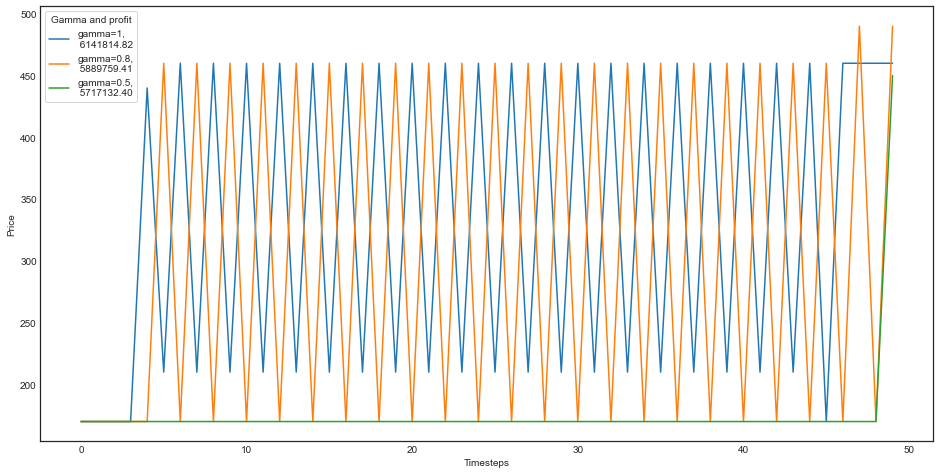

In [13]:
plt.figure(figsize=(16, 8))
plt.xlabel("Timesteps")
plt.ylabel("Price")
for key, value in result.items():
    plt.plot(range(T), value['plot'])
plt.legend([f"{key},\n {result[key]['profit']:.2f}" for key in result.keys()], loc='upper left', frameon=True, title="Gamma and profit")

In [ ]:
%load_ext tensorboard

In [30]:
%tensorboard --logdir ./dqn_price_lh_tensorboard/

In [32]:
from stable_baselines3 import A2C
result = {}

def experement(result, gamma=1):
    obs = pricing_env.reset()
    policy_kwargs = dict(activation_fn=th.nn.ReLU,
                         net_arch=[128, dict(pi=[128,128], vf=[128, 128])])

    model = A2C("MlpPolicy", pricing_env, gamma=gamma, policy_kwargs=policy_kwargs, 
                tensorboard_log="./a2c_price_lh_tensorboard/")
    model.learn(total_timesteps=10000, log_interval=100)
    obs = pricing_env.reset()
    for _ in range(T):
        action, _ = model.predict(obs, deterministic=True)
        obs, _, _, _ = pricing_env.step(action)
    result[f"gamma={gamma}"]= {'plot': obs[0:T],
                               'profit': profit_response(obs[0:T])}

experement(result, gamma=0.99)
experement(result, gamma=0.8)
experement(result, gamma=0.5)

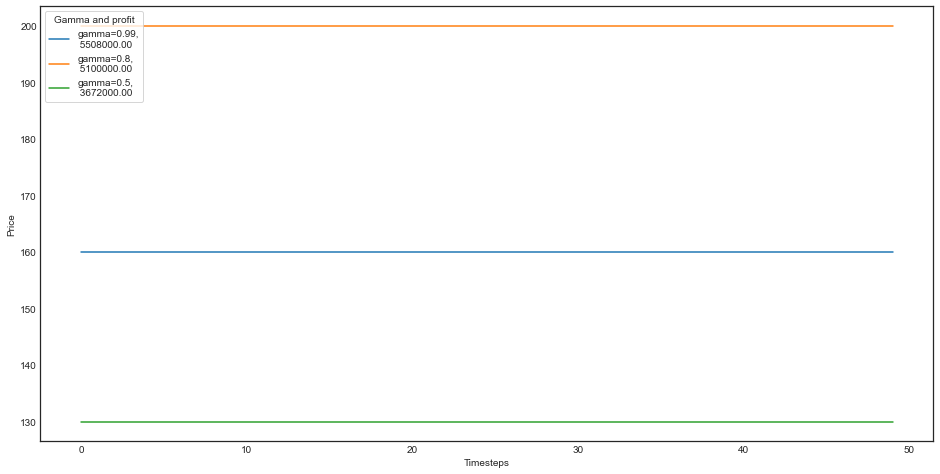

In [33]:
plt.figure(figsize=(16, 8))
plt.xlabel("Timesteps")
plt.ylabel("Price")
for key, value in result.items():
    plt.plot(range(T), value['plot'])
plt.legend([f"{key},\n {result[key]['profit']:.2f}" for key in result.keys()], loc='upper left', frameon=True, title="Gamma and profit")

In [34]:
%tensorboard --logdir ./dqn_price_lh_tensorboard/

Reusing TensorBoard on port 6007 (pid 45095), started 0:01:18 ago. (Use '!kill 45095' to kill it.)